<center><h2>Example 1: Calculate the potential energy surface </h2> </center> <br>
---
    
    
This notebook builds the potential energy surface (PES) of pairs of molecules along characteristic coordinates. N-dimensional scans can be performed and plotted to show the PES.<br>
<br>

 <i>Author</i>: <a href="https://github.com/oosode">Olaseni Sode</a> <br>
 <i>Created on</i>: June 1, 2018 <br>
 <i>Tags</i>: PES, electronic structure<br>

# Contents

---
   - [0. Load imports](#0.-Load-imports)
   - [1. Load dfk and functions](#1.-Load-dfk-and-functions)
   - [2. Choose molecules](#2.-Choose-molecules)
   - [3. Pick theory](#3.-Pick-theory)
   - [4. Optimize monomers](#4.-Optimize-monomers)
   - [5. Configure dimer](#5.-Configure-dimer)
   - [6. Optimize dimer](#6.-Optimize-dimer)
   - [7. Setup PES scan](#7.-Setup-scan)
   - [8. PES scan](#8.-PES-scan)
   - [9. Plot PES](#9.-Plot-PES)

## 0. Load imports

This cell imports the necessary modules. To execute a cell, click on it, then press <kbd>shift</kbd> + <kbd>enter</kbd>. (If you're new to the notebook environment, you may want to check out [this helpful cheat sheet](https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb)).

In [127]:
import os
import sys
import gc
import parsl
import py3Dmol
import types
import scipy.ndimage

import ipywidgets as widgets
from subprocess import Popen, PIPE
from parsl import *
from math import *
from copy import *

#from molecule import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cirpy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

print(parsl.__version__)

0.5.1


## 1. Load dfk and functions

The following cells are used to load the data flow kernel need for parsl and the other necessary python functions needed to perform the potential energy surface scan. 

#### Load data flow kernel

In [128]:
from parsl.configs.local import localThreads

config = {
    "sites": [
        {
            "site": "midway_ipp_multicore",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    "taskBlocks": 1, # tasks per block
                    #"taskBlocks":20, 
                    "walltime": "00:05:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 10,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }, 
        {
            "site": "midway_ipp_singlenode",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    #"taskBlocks": 1, # tasks per block
                    "taskBlocks":20, 
                    "walltime": "00:15:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 1,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }
        
    ],
    "globals": {
        "lazyErrors": True,
    },
    #"controller" : {'publicIp' : ''}
}

#dfk = DataFlowKernel(config=config)
dfk = DataFlowKernel(config=localThreads)

In [129]:
import element

class molecule:
    def __init__(self,name,nmols):
        print("Intialized new molecule class: %s"%(name))
        self.name = name
        self.nmols = nmols
        self.coord = []
        self.mass = []
        self.atom = []
        self.frag = []

        return

    def resolve(self):
        res=cirpy.resolve(self.name, 'xyz')
        print("Resolved chemical identification of %s"%(self.name))
        r=res.split("\n")
        self.natoms=int(r[0])
        self.frag=[0]*self.natoms

        for i,line in enumerate(r):
            if i<=1:
                continue
            elif i<self.natoms+2:
                tmp=[float(line.split()[1]),
                     float(line.split()[2]),
                     float(line.split()[3])]
                self.coord.append(tmp)
                self.atom.append(line.split()[0])
                self.mass.append(element.ELEMENTS[self.atom[-1]].mass)
            else:
                continue
        return
    
    def init_dimer(self,m1,m2):
        
        
        self.name=m1.name+"-"+m2.name
        self.nmols=2
        self.coord=deepcopy(m1.coord)+deepcopy(m2.coord)
        self.mass=deepcopy(m1.mass)+deepcopy(m2.mass)
        self.natoms=m1.natoms+m2.natoms
        self.atom=deepcopy(m1.atom)+deepcopy(m2.atom)
        self.frag=[0]*m1.natoms+[1]*m2.natoms

        return
    
    def xyz(self):
        
        string="%d\n\n"%(self.natoms)
        for c,coord in enumerate(self.coord):
            string+="%-2s "%(self.atom[c])
            string+="%15.10f %15.10f %15.10f\n"%(coord[0],
                                                 coord[1],
                                                 coord[2])
            
        return string
        
    def print_xyz(self):
        
        string="%d\n\n"%(self.natoms)
        for c,coord in enumerate(self.coord):
            string+="%-2s "%(self.atom[c])
            string+="%15.10f %15.10f %15.10f\n"%(coord[0],
                                                 coord[1],
                                                 coord[2])
        print(string)
        return
    
    def calculate_com(self):
    
        if self.nmols==1:
            x=0.0
            y=0.0
            z=0.0

            totalmass=0.0

            for a,atom in enumerate(self.coord):

                x+=atom[0]*self.mass[a]
                y+=atom[1]*self.mass[a]
                z+=atom[2]*self.mass[a]
                totalmass+=self.mass[a]

            x=x/totalmass
            y=y/totalmass
            z=z/totalmass

            self.com=[x,y,z]

        elif self.nmols==2:

            x1=x2=0.0
            y1=y2=0.0
            z1=z2=0.0

            totalmass1=totalmass2=0.0

            for c,coord in enumerate(self.coord):

                if self.frag[c]==0:
                    x1+=coord[0]*self.mass[c]
                    y1+=coord[1]*self.mass[c]
                    z1+=coord[2]*self.mass[c]
                    totalmass1+=self.mass[c]
                elif self.frag[c]==1:
                    x2+=coord[0]*self.mass[c]
                    y2+=coord[1]*self.mass[c]
                    z2+=coord[2]*self.mass[c]
                    totalmass2+=self.mass[c]

            x1=x1/totalmass1
            y1=y1/totalmass1
            z1=z1/totalmass1
                   
            x2=x2/totalmass2
            y2=y2/totalmass2
            z2=z2/totalmass2

            self.com=[x1,y1,z1,x2,y2,z2]
                   
        return
   
    def calculate_vector(self):
        """Function to calculate normalized vector."""

        self.calculate_com()
        
        for l in range(3):
            x=self.com[3]-self.com[0]
            y=self.com[4]-self.com[1]
            z=self.com[5]-self.com[2]
            
        norm=sqrt(x*x + y*y + z*z)
        self.vector=[x/norm,y/norm,z/norm]
        self.radius=norm
        
        return

    
    def center(self):

        self.calculate_com()
        f=self.frag
                   
        for c,coord in enumerate(self.coord):
            coord[0]-=self.com[0+f[c]*3]
            coord[1]-=self.com[1+f[c]*3]
            coord[2]-=self.com[2+f[c]*3]         

        return

#     def rotate_theta(self,theta,mID):

#         if mID!=0 and self.nmols==1:
#             print("This is a single molecule. The molecule ID should be zero.")  
            
#         for c,coord in enumerate(self.coord):
            
#             if self.frag[c]==mID:
#                 x=coord[0]
#                 y=coord[1]
#                 z=coord[2]

#                 r=sqrt(x*x + y*y + z*z)
#                 if r<1.0e-10:
#                     continue
                    
#                 #t=acos(z/r)
#                 t=atan2(r,z)
#                 print(t,t-radians(theta))
#                 p=atan2(y,x)
#                 print()
#                 t+=radians(theta)

#                 coord[0]=r*sin(t)*cos(p)
#                 coord[1]=r*sin(t)*sin(p)
#                 coord[2]=r*cos(t)

#         return
    
#     def rotate_phi(self,phi,mID):
        
#         if mID!=0 and self.nmols==1:
#             print("This is a single molecule. The molecule ID should be zero.")  
            
#         for c,coord in enumerate(self.coord):
            
#             if self.frag[c]==mID:
#                 x=coord[0]
#                 y=coord[1]
#                 z=coord[2]

#                 r=sqrt(x*x + y*y + z*z)
#                 if r<1.0e-10:
#                     continue
                    
#                 #t=acos(z/r)
#                 t=atan2(r,z)
#                 p=atan2(y,x)
#                 p+=radians(phi)

#                 coord[0]=r*sin(t)*cos(p)
#                 coord[1]=r*sin(t)*sin(p)
#                 coord[2]=r*cos(t)

#         return    
    
    def rotate(self,angle,axis,mID):
        """https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula"""
        
        if mID!=0 and self.nmols==1:
            print("This is a single molecule. The molecule ID should be zero.")  
        
        if axis=="x":
            k=(1,0,0) #unit vector
        elif axis=="y":
            k=(0,1,0)
        elif axis=="z":
            k=(0,0,1)
        else:
            if isinstance(var, types.StringTypes) or len(axis)!=3:
                 raise IOError("Unknown axis in rotate function.")
            else:
                norm=np.linalg.norm(axis)
                k=(axis[0]/norm,axis[1]/norm,axis[2]/norm)
                
        cosA=cos(radians(angle)) # cosine of angle
        sinA=sin(radians(angle)) # sine of angle
    
        for c,coord in enumerate(self.coord):
            
            if self.frag[c]==mID:
                
                term0=[l*cosA for l in coord]
                
                kxv=np.cross(k,coord).tolist() # cross of k and v
                term1=[l*sinA for l in kxv]
                
                kv=np.dot(k,coord).tolist()
                term2=[l*(1-cosA)*kv for l in k]

                for l in range(3):
                    coord[l]=term0[l]+term1[l]+term2[l]

        return        

    def position(self,R,theta,phi):
        
        if self.nmols==1:
            print("This is a single molecule. The `position_molecule` function is for dimers.")        

        x=R*sin(radians(theta))*cos(radians(phi))
        y=R*sin(radians(theta))*sin(radians(phi))
        z=R*cos(radians(theta))

        for c,coord in enumerate(self.coord):
            
            if self.frag[c]==1:
                coord[0]+=x
                coord[1]+=y
                coord[2]+=z

        return    
    
    def setup_dimer(self):
        """This function that each monomer is initially at the origin, before
        transformation."""
        
        self.calculate_com()
        #self.R=0.0 # initial dimer distance
        #self.tv=[0.0]*3 # initial dimer vector
        self.center()
        return
        
    def transform_dimer(self,value,transform,unit,mID):
        """This function prepares the dimer according to the type and magnitude 
        of transformation. Since translations shift the dimer off the origin, this
        operation is always perfomed last in the `set dimer` function."""
        
        if transform=="translation": # make translational vector
            self.radius=value
            if unit==False:
                pass
            else:
                self.vector=unit
            
        elif transform=="angle": # rotate molecules
            
            norm=np.linalg.norm(unit)
            k=(unit[0]/norm,unit[1]/norm,unit[2]/norm)
                
            cosA=cos(radians(value)) # cosine of angle
            sinA=sin(radians(value)) # sine of angle
    
            for c,coord in enumerate(self.coord):
            
                if self.frag[c]==mID:
                
                    term0=[l*cosA for l in coord]
                
                    kxv=np.cross(k,coord).tolist() # cross of k and v
                    term1=[l*sinA for l in kxv]
                
                    kv=np.dot(k,coord).tolist()
                    term2=[l*(1-cosA)*kv for l in k]

                    for l in range(3):
                        coord[l]=term0[l]+term1[l]+term2[l]
            
        else:
            raise IOError("Unknown transformation.")
            
        return
            
    def set_dimer(self):
        """"""
        
        for c,coord in enumerate(self.coord):
            if self.frag[c]==1:
                coord[0]+=self.vector[0]*self.radius
                coord[1]+=self.vector[1]*self.radius
                coord[2]+=self.vector[2]*self.radius
                
        return



#### Function to write electronic structure input files

In [130]:
def write_input(ID,mol,theory,basis,program,optimization,f12,cp):
    
    natoms=int(mol.natoms)
    
    if program=="MOLPRO":
        
        fout=open("%s.%06d.com"%("molpro",ID),"w")
        fout.write("***, %s %s \n"%(mol.name,optimization))
        fout.write("memory,100,M\n")
        fout.write("geometry={\n")
        
        for i in range(natoms):

            fout.write("%s%d "%(mol.atom[i],i))
            fout.write("%15.10f, %15.10f, %15.10f"%(mol.coord[i][0],\
                                                    mol.coord[i][1],\
                                                    mol.coord[i][2]))
            if i==natoms-1:
                fout.write("}\n")
            else:
                fout.write("\n")

        fout.write("basis=%s"%(basis))
        fout.write("\n")

        if cp:
            #This functionality doesn't exist yet.
            pass
        #    fout.write("text,cp calculation for %s %dmer_%i\n"%(name,m,n))
        #    fout.write("dummy,")
        #    for i in range(atoms):
        #        if molid[i] in dum:
        #            tmp=index*atoms
        #            fout.write("%s%d,"%(names[tmp+i],i))
        #            fout.write("\n")
        #        else:
        #            fout.write("text,calculation for %s %dmer\n"%(name,m))

        if theory!="hf":
            fout.write("hf\n")
            fout.write("%s"%(theory))
            if f12:
                fout.write("-f12\n")
            else:
                fout.write("\n")
        else:
            fout.write("hf\n")
            
        if optimization=="Minimum":
            fout.write("optg\n")
            fout.write("maxit=50\n")
        if optimization=="Saddle":
            fout.write("optg")

        fout.write("e_mer=energy\n")
        if (f12):
            fout.write("e_mer_F12a=energy(1)\n")
            fout.write("e_mer_F12b=energy(2)\n")
        fout.write("\n")
        fout.close()
        return
        
    if program=="NWChem":
        pass

#### Function to run electronic structure program

In [131]:
@App('bash', dfk)
def molpro(ID, outputs=[], stderr=None, stdout=None):
    #return "uname -a; /home/oosode/software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)
    return "uname -a; /Users/oosode/Software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)

#### Function to read electronic structure ouptut

In [132]:
def read_output(ID,program,mol):
    
    energy={}
    
    if program=="MOLPRO": 
        
        c=False
        fout="molpro.%06d.out"%(ID)
        if not os.path.isfile(fout):
            raiseIOError("No file for molpro.%06d.com"%(ID))

        else:
            fl=open(fout).readlines()

            for l in range(len(fl)-1,len(fl)-5,-1):
                if fl[l].find("Variable memory released")>=0:
                    c=True
                    break

            if (not c):
                energy[0]="inf"
                print("No energies for file molpro.%06d.com"%(ID))
                return

            else:
                for l,line in enumerate(fl):
                    if line.find("SETTING E_MER ")>=0: # energy
                        #print("hello")
                        energy['simple']=float(line.strip().split()[-2].replace("D","E"))
                    
                        mol.energy=energy
                        #print(mol['energy'])
                        
                    #if line.find("SETTING E_MER_F12A ")>=0: # F12a energy
                    #    energy['f12a']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    #elif line.find("SETTING E_MER_F12B ")>=0: # F12b energy
                    #    energy['f12b']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    
                    elif line.find("END OF GEOMETRY OPTIMIZATION.")>=0:
                        natoms=int(fl[l+4].split()[0])
                        if natoms != mol.natoms:
                            print("There is a mismatch in the number of atoms")
                        for n in range(natoms):
                            for i in range(3):
                                mol.coord[n][i]=float(fl[l+6+n].split()[i+1])
                    
            return


#### Function to setup the PES scan.

In [160]:
def PES_scan(dim,variables,nCUP):
    
    # do pes scan
    sList = [] # list dimers to scan
    
    if nCUP==1:
        for m in range(len(variables)):
            
            var0=deepcopy(variables[m])
            
            for v0 in iter(deepcopy(variables[m])):
                
                tmp=deepcopy(dim) # copy dimer
                tmp.setup_dimer() 
                tmp.transform_dimer(v0,var0.name,var0.unit,var0.molID)
                tmp.set_dimer()
                sList.append(tmp)
                
    elif nCUP==2:
        for m in range(len(variables)):
            for n in range(m+1,len(variables)):
                
                var0=deepcopy(variables[m])
                var1=deepcopy(variables[n])
                
                for v0 in iter(deepcopy(variables[m])):
                    for v1 in iter(deepcopy(variables[n])):
                        
                        #print(v0,v1)
                        
                        tmp=deepcopy(dim) # copy dimer
                        tmp.setup_dimer() 
                        tmp.transform_dimer(v0,var0.name,var0.unit,var0.molID)
                        tmp.transform_dimer(v1,var1.name,var1.unit,var1.molID)
                        tmp.set_dimer()
                        sList.append(tmp)
    
    else:
        print("The coupling between variables (ncup) must be set to either 0 or 1.")
                
    print(len(sList))      
    return sList

#### Class that defines the different variables.

In [134]:
class Var:
    def __init__(self,name,minimum,maximum,inc,unit,mID=1):
        self.name=name
        self.min=minimum
        self.max=maximum
        self.inc=inc
        self.unit=unit
        self.molID=mID
        self.current=self.min
        return
        
    def determine_range(self):
        x=self.min
        tmp=[]
        while x<=self.max:
            tmp.append(x)
            x+=self.inc
        self.ranges=tuple(tmp)
        return
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.current > self.max:
            raise StopIteration
        else:
            self.current += self.inc
            return self.current - self.inc
        

## 2. Choose molecules

The cells below allows you to pick the two types of molecules for the PES scan. It uses the cirpy module to resolve the name of the molecules and then loads the xyz coordinates and atom names into the `molecule` class. This class then configures the remaining values including atomic mass, number of atoms, etc. 

**NOTE:** You can change the molecule types from the default "carbon dioxide" to any other molecule in the chemical information resolver database. Just change the name below.

In [135]:
mol0 = molecule("CO2",1) # name and number of molecules
mol0.resolve()

mol1 = molecule("H2O",1)
mol1.resolve()

mList = (mol0,mol1)

Intialized new molecule class: CO2
Resolved chemical identification of CO2
Intialized new molecule class: H2O
Resolved chemical identification of H2O


In [136]:
view0 = py3Dmol.view(width=800,height=400,linked=False,viewergrid=(1,2))
#view0.removeAllModels(viewer=(0,0))
view0.addModel(mol0.xyz(),'xyz',viewer=(0,0))
view0.addModel(mol1.xyz(),'xyz',viewer=(0,1))
view0.setStyle({'sphere':{}})
view0.setBackgroundColor('0xeeeeee')
view0.zoomTo(viewer=(0,0))
#view0.render()
view0.show()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3. Pick theory

The cells below allows you to choose the level of electronic structure theory, the basis set, the use of explicit correlation and the electronic structure program. (Currently, only the MOLPRO software package is implemented.) 

Some configurations of theory, basis set and programs are not possible. Once you have selected your program variables, make sure to check the configurations availability with the `wrapper.check()` function.


In [137]:
theory="HF"
basis="aug-cc-pVDZ"
f12=False
program="MOLPRO"

## 4. Optimize monomers

You can optimize the two monomers in the cells below. In the first cell, the input files are written. The second cell submits the input files and waits for them to finish. The last cell parses the output file and recovers the data. When running jobs on a compute cluster, the status of the job can be checked using the `qstat` command. The final energy and cartesian coordinates of the geometry are printed. 

**Write input files**:

In [138]:
for ID in range(2):
    write_input(ID,mList[ID],theory,basis,program,"Minimum",f12,False)

**Run calculations**:

In [139]:
futures=[]
for ID in range(2):
    #run_input(ID,program)
    out="molpro.%06d.out"%(ID)
    xml="molpro.%06d.xml"%(ID)
    futures.append(molpro(ID, outputs=[out,xml]))


print([x.result() for x in futures]) 

[0, 0]


**Check status**:

In [140]:
#!qstat -u $USER
!ls -lt | head -10
#!tail molpro.000000.out

total 35808
-rw-r--r--   1 oosode  staff   39757 Jun 23 15:38 molpro.000000.log
-rw-r--r--   1 oosode  staff   17326 Jun 23 15:38 molpro.000000.out
-rw-r--r--   1 oosode  staff   26895 Jun 23 15:38 molpro.000000.xml
-rw-r--r--   1 oosode  staff   45466 Jun 23 15:38 molpro.000001.log
-rw-r--r--   1 oosode  staff   16163 Jun 23 15:38 molpro.000001.out
-rw-r--r--   1 oosode  staff   27507 Jun 23 15:38 molpro.000001.xml
-rw-r--r--   1 oosode  staff     254 Jun 23 15:38 molpro.000000.com
-rw-r--r--   1 oosode  staff     254 Jun 23 15:38 molpro.000001.com
drwxr-xr-x  41 oosode  staff    1394 Jun 23 15:37 runinfo


**Read output**:

In [141]:
for ID in range(2):
    read_output(ID,program,mList[ID])

## 5. Configure dimer position

Once the isolated monomers are obtained (and optimized), the next step is to orient them with respect to one another. This is done using a spherical coordinate space, shown below. The __orientation of molecule 1__ and the __orientation of molecule 2__ are determined first, followed by the __position__ of molecule 2 relative to molecule 1. 

Molecule 1 is always placed at the origin (0,0,0) oriented in space with $\theta_1$ and $\phi_1$. The range of $\theta_1$ is [0°, 180°] and the range of $\phi_1$ is [0, 360°). Molecule 2 is placed using spherical coordinates at some distance R from the origin, with $\theta_d$ and $\phi_d$ ranging from [0°, 180°] and [0, 360°), respectively. The orientation of Molecule 2 is denoted by $\theta_2$ and $\phi_2$ values. All angles are in degree units and distances are in angstroms.

<img src='https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Spherical.svg' style="width: 300px;">

The molecules are oriented such that the x-axis runs horizontally across the screen, the y-axis runs vertically, and the z-axis emerges from the plane of the computer screen.

#### Orientation and position molecules

In [148]:
# orientation of molecule 1
x1_rotation = 0
y1_rotation = 0
z1_rotation = 0

# orientation of molecule 2
x2_rotation = 0
y2_rotation = 90
z2_rotation = 0

# make monomer list
xList = (x1_rotation,x2_rotation)
yList = (y1_rotation,y2_rotation)
zList = (z1_rotation,z2_rotation)

# position molecule 2
R = 4.0
theta_d = 90
phi_d = -90

#### Orient dimer

In [149]:
tmp_mList=[]
for i,m in enumerate(mList):
    
    tmp_m = deepcopy(m)
    tmp_m.calculate_com()
    tmp_m.center()
    tmp_m.rotate(xList[i],"x",0)
    tmp_m.rotate(yList[i],"y",0)
    tmp_m.rotate(zList[i],"z",0)
    tmp_mList.append(tmp_m)

dimer=molecule("whatever",1)
dimer.init_dimer(tmp_mList[0],tmp_mList[1])
dimer.position(R,theta_d,phi_d)
dimer.calculate_vector()


Intialized new molecule class: whatever


#### Show dimer

In [151]:
view1 = py3Dmol.view(width=800,height=300)
view1.addModel(dimer.xyz(),'xyz')
view1.setStyle({'stick':{}})
view1.setBackgroundColor('0xeeeeee')
view1.show()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If you are unhappy with the orientation of the dimer, you may return to the `Orientation and position of molecules` cell and adjust the angles and radial distances to your liking. Also, one should consider optimizing the dimer to either a local minimum or saddle point in the following cell.

## 6. Optimize dimer structure

The dimer structure can be optimized such that any potential energy scan originates from either a global or local minimum, or a saddle point. To optimize to a minimum, set the optimization flag to `Minimum`, and to optimize to a saddle point, set the optimization variable to `Saddle`. If you prefer not to optimize the dimer further, specify `None`.



In [152]:
optimization="None"

In [154]:
if optimization=="None":
    pass

elif optimization=="Minimum" or "Saddle":
    write_input(3,dim,theory,basis,program,optimization,f12,False)
    out="molpro.%06d.out"%(ID)
    xml="molpro.%06d.xml"%(ID)
    fut = molpro(3, outputs=[out,xml])
    print([fut.result()]) 
    read_output(3,program)
    
else:
    raise IOError("Unknown optimization.")

## 7. Setup scan

The potential energy surface will be scanned along some characteristic coordinate(s). There is no limit to the number coordinates to scan however, the maximum coupling between coordinates is 2. Some examples of coordinates include the 'R' distance, the $\phi_1$ angle or the $\theta_d$ angle. For each coordinate, the range of values and the increment must be specified. Increments for distances are in angstroms and are in degrees for angles. 

**Which variables?**

In [155]:
variables=[]

Rname = 'translation'
Rmini = 2.0
Rmaxi = 8.0
Rincr = 0.1
Runit = False # scan along what vector from molecule 1. False is distance vector
RID = 1 # this value should always be one for translations

var1=Var(Rname,Rmini,Rmaxi,Rincr,Runit,1)
var1.determine_range()
variables.append(var1)

Aname = 'angle'
Amini = -90.0
Amaxi =  90.0
Aincr =  01.0
Aunit = (1,0,0) # rotate about what axis 
AID = 0

var2=Var(Aname,Amini,Amaxi,Aincr,Aunit,AID)
var2.determine_range()
variables.append(var2)

**number of variable coupling?**

In [156]:
nCUP=2

## 8. PES scan

Once the scan variables are determined, proceed through the next cells to perform electronic structure calculations on each of the dimer configurations.

#### Determine dimer configurations

This also prints the number of configurations to evaluate.

In [158]:
dimer_scans=PES_scan(dimer,variables,nCUP)

2.0 -90.0
2.0 -89.0
2.0 -88.0
2.0 -87.0
2.0 -86.0
2.0 -85.0
2.0 -84.0
2.0 -83.0
2.0 -82.0
2.0 -81.0
2.0 -80.0
2.0 -79.0
2.0 -78.0
2.0 -77.0
2.0 -76.0
2.0 -75.0
2.0 -74.0
2.0 -73.0
2.0 -72.0
2.0 -71.0
2.0 -70.0
2.0 -69.0
2.0 -68.0
2.0 -67.0
2.0 -66.0
2.0 -65.0
2.0 -64.0
2.0 -63.0
2.0 -62.0
2.0 -61.0
2.0 -60.0
2.0 -59.0
2.0 -58.0
2.0 -57.0
2.0 -56.0
2.0 -55.0
2.0 -54.0
2.0 -53.0
2.0 -52.0
2.0 -51.0
2.0 -50.0
2.0 -49.0
2.0 -48.0
2.0 -47.0
2.0 -46.0
2.0 -45.0
2.0 -44.0
2.0 -43.0
2.0 -42.0
2.0 -41.0
2.0 -40.0
2.0 -39.0
2.0 -38.0
2.0 -37.0
2.0 -36.0
2.0 -35.0
2.0 -34.0
2.0 -33.0
2.0 -32.0
2.0 -31.0
2.0 -30.0
2.0 -29.0
2.0 -28.0
2.0 -27.0
2.0 -26.0
2.0 -25.0
2.0 -24.0
2.0 -23.0
2.0 -22.0
2.0 -21.0
2.0 -20.0
2.0 -19.0
2.0 -18.0
2.0 -17.0
2.0 -16.0
2.0 -15.0
2.0 -14.0
2.0 -13.0
2.0 -12.0
2.0 -11.0
2.0 -10.0
2.0 -9.0
2.0 -8.0
2.0 -7.0
2.0 -6.0
2.0 -5.0
2.0 -4.0
2.0 -3.0
2.0 -2.0
2.0 -1.0
2.0 0.0
2.0 1.0
2.0 2.0
2.0 3.0
2.0 4.0
2.0 5.0
2.0 6.0
2.0 7.0
2.0 8.0
2.0 9.0
2.0 10.0
2.0 11.0
2.0 12.0
2.

2.4000000000000004 -29.0
2.4000000000000004 -28.0
2.4000000000000004 -27.0
2.4000000000000004 -26.0
2.4000000000000004 -25.0
2.4000000000000004 -24.0
2.4000000000000004 -23.0
2.4000000000000004 -22.0
2.4000000000000004 -21.0
2.4000000000000004 -20.0
2.4000000000000004 -19.0
2.4000000000000004 -18.0
2.4000000000000004 -17.0
2.4000000000000004 -16.0
2.4000000000000004 -15.0
2.4000000000000004 -14.0
2.4000000000000004 -13.0
2.4000000000000004 -12.0
2.4000000000000004 -11.0
2.4000000000000004 -10.0
2.4000000000000004 -9.0
2.4000000000000004 -8.0
2.4000000000000004 -7.0
2.4000000000000004 -6.0
2.4000000000000004 -5.0
2.4000000000000004 -4.0
2.4000000000000004 -3.0
2.4000000000000004 -2.0
2.4000000000000004 -1.0
2.4000000000000004 0.0
2.4000000000000004 1.0
2.4000000000000004 2.0
2.4000000000000004 3.0
2.4000000000000004 4.0
2.4000000000000004 5.0
2.4000000000000004 6.0
2.4000000000000004 7.0
2.4000000000000004 8.0
2.4000000000000004 9.0
2.4000000000000004 10.0
2.4000000000000004 11.0
2.4000

2.6000000000000005 42.0
2.6000000000000005 43.0
2.6000000000000005 44.0
2.6000000000000005 45.0
2.6000000000000005 46.0
2.6000000000000005 47.0
2.6000000000000005 48.0
2.6000000000000005 49.0
2.6000000000000005 50.0
2.6000000000000005 51.0
2.6000000000000005 52.0
2.6000000000000005 53.0
2.6000000000000005 54.0
2.6000000000000005 55.0
2.6000000000000005 56.0
2.6000000000000005 57.0
2.6000000000000005 58.0
2.6000000000000005 59.0
2.6000000000000005 60.0
2.6000000000000005 61.0
2.6000000000000005 62.0
2.6000000000000005 63.0
2.6000000000000005 64.0
2.6000000000000005 65.0
2.6000000000000005 66.0
2.6000000000000005 67.0
2.6000000000000005 68.0
2.6000000000000005 69.0
2.6000000000000005 70.0
2.6000000000000005 71.0
2.6000000000000005 72.0
2.6000000000000005 73.0
2.6000000000000005 74.0
2.6000000000000005 75.0
2.6000000000000005 76.0
2.6000000000000005 77.0
2.6000000000000005 78.0
2.6000000000000005 79.0
2.6000000000000005 80.0
2.6000000000000005 81.0
2.6000000000000005 82.0
2.60000000000000

2.900000000000001 -44.0
2.900000000000001 -43.0
2.900000000000001 -42.0
2.900000000000001 -41.0
2.900000000000001 -40.0
2.900000000000001 -39.0
2.900000000000001 -38.0
2.900000000000001 -37.0
2.900000000000001 -36.0
2.900000000000001 -35.0
2.900000000000001 -34.0
2.900000000000001 -33.0
2.900000000000001 -32.0
2.900000000000001 -31.0
2.900000000000001 -30.0
2.900000000000001 -29.0
2.900000000000001 -28.0
2.900000000000001 -27.0
2.900000000000001 -26.0
2.900000000000001 -25.0
2.900000000000001 -24.0
2.900000000000001 -23.0
2.900000000000001 -22.0
2.900000000000001 -21.0
2.900000000000001 -20.0
2.900000000000001 -19.0
2.900000000000001 -18.0
2.900000000000001 -17.0
2.900000000000001 -16.0
2.900000000000001 -15.0
2.900000000000001 -14.0
2.900000000000001 -13.0
2.900000000000001 -12.0
2.900000000000001 -11.0
2.900000000000001 -10.0
2.900000000000001 -9.0
2.900000000000001 -8.0
2.900000000000001 -7.0
2.900000000000001 -6.0
2.900000000000001 -5.0
2.900000000000001 -4.0
2.900000000000001 -3.0

3.100000000000001 67.0
3.100000000000001 68.0
3.100000000000001 69.0
3.100000000000001 70.0
3.100000000000001 71.0
3.100000000000001 72.0
3.100000000000001 73.0
3.100000000000001 74.0
3.100000000000001 75.0
3.100000000000001 76.0
3.100000000000001 77.0
3.100000000000001 78.0
3.100000000000001 79.0
3.100000000000001 80.0
3.100000000000001 81.0
3.100000000000001 82.0
3.100000000000001 83.0
3.100000000000001 84.0
3.100000000000001 85.0
3.100000000000001 86.0
3.100000000000001 87.0
3.100000000000001 88.0
3.100000000000001 89.0
3.100000000000001 90.0
3.200000000000001 -90.0
3.200000000000001 -89.0
3.200000000000001 -88.0
3.200000000000001 -87.0
3.200000000000001 -86.0
3.200000000000001 -85.0
3.200000000000001 -84.0
3.200000000000001 -83.0
3.200000000000001 -82.0
3.200000000000001 -81.0
3.200000000000001 -80.0
3.200000000000001 -79.0
3.200000000000001 -78.0
3.200000000000001 -77.0
3.200000000000001 -76.0
3.200000000000001 -75.0
3.200000000000001 -74.0
3.200000000000001 -73.0
3.20000000000000

3.300000000000001 66.0
3.300000000000001 67.0
3.300000000000001 68.0
3.300000000000001 69.0
3.300000000000001 70.0
3.300000000000001 71.0
3.300000000000001 72.0
3.300000000000001 73.0
3.300000000000001 74.0
3.300000000000001 75.0
3.300000000000001 76.0
3.300000000000001 77.0
3.300000000000001 78.0
3.300000000000001 79.0
3.300000000000001 80.0
3.300000000000001 81.0
3.300000000000001 82.0
3.300000000000001 83.0
3.300000000000001 84.0
3.300000000000001 85.0
3.300000000000001 86.0
3.300000000000001 87.0
3.300000000000001 88.0
3.300000000000001 89.0
3.300000000000001 90.0
3.4000000000000012 -90.0
3.4000000000000012 -89.0
3.4000000000000012 -88.0
3.4000000000000012 -87.0
3.4000000000000012 -86.0
3.4000000000000012 -85.0
3.4000000000000012 -84.0
3.4000000000000012 -83.0
3.4000000000000012 -82.0
3.4000000000000012 -81.0
3.4000000000000012 -80.0
3.4000000000000012 -79.0
3.4000000000000012 -78.0
3.4000000000000012 -77.0
3.4000000000000012 -76.0
3.4000000000000012 -75.0
3.4000000000000012 -74.0


3.6000000000000014 -78.0
3.6000000000000014 -77.0
3.6000000000000014 -76.0
3.6000000000000014 -75.0
3.6000000000000014 -74.0
3.6000000000000014 -73.0
3.6000000000000014 -72.0
3.6000000000000014 -71.0
3.6000000000000014 -70.0
3.6000000000000014 -69.0
3.6000000000000014 -68.0
3.6000000000000014 -67.0
3.6000000000000014 -66.0
3.6000000000000014 -65.0
3.6000000000000014 -64.0
3.6000000000000014 -63.0
3.6000000000000014 -62.0
3.6000000000000014 -61.0
3.6000000000000014 -60.0
3.6000000000000014 -59.0
3.6000000000000014 -58.0
3.6000000000000014 -57.0
3.6000000000000014 -56.0
3.6000000000000014 -55.0
3.6000000000000014 -54.0
3.6000000000000014 -53.0
3.6000000000000014 -52.0
3.6000000000000014 -51.0
3.6000000000000014 -50.0
3.6000000000000014 -49.0
3.6000000000000014 -48.0
3.6000000000000014 -47.0
3.6000000000000014 -46.0
3.6000000000000014 -45.0
3.6000000000000014 -44.0
3.6000000000000014 -43.0
3.6000000000000014 -42.0
3.6000000000000014 -41.0
3.6000000000000014 -40.0
3.6000000000000014 -39.0


3.8000000000000016 -87.0
3.8000000000000016 -86.0
3.8000000000000016 -85.0
3.8000000000000016 -84.0
3.8000000000000016 -83.0
3.8000000000000016 -82.0
3.8000000000000016 -81.0
3.8000000000000016 -80.0
3.8000000000000016 -79.0
3.8000000000000016 -78.0
3.8000000000000016 -77.0
3.8000000000000016 -76.0
3.8000000000000016 -75.0
3.8000000000000016 -74.0
3.8000000000000016 -73.0
3.8000000000000016 -72.0
3.8000000000000016 -71.0
3.8000000000000016 -70.0
3.8000000000000016 -69.0
3.8000000000000016 -68.0
3.8000000000000016 -67.0
3.8000000000000016 -66.0
3.8000000000000016 -65.0
3.8000000000000016 -64.0
3.8000000000000016 -63.0
3.8000000000000016 -62.0
3.8000000000000016 -61.0
3.8000000000000016 -60.0
3.8000000000000016 -59.0
3.8000000000000016 -58.0
3.8000000000000016 -57.0
3.8000000000000016 -56.0
3.8000000000000016 -55.0
3.8000000000000016 -54.0
3.8000000000000016 -53.0
3.8000000000000016 -52.0
3.8000000000000016 -51.0
3.8000000000000016 -50.0
3.8000000000000016 -49.0
3.8000000000000016 -48.0


4.000000000000002 -64.0
4.000000000000002 -63.0
4.000000000000002 -62.0
4.000000000000002 -61.0
4.000000000000002 -60.0
4.000000000000002 -59.0
4.000000000000002 -58.0
4.000000000000002 -57.0
4.000000000000002 -56.0
4.000000000000002 -55.0
4.000000000000002 -54.0
4.000000000000002 -53.0
4.000000000000002 -52.0
4.000000000000002 -51.0
4.000000000000002 -50.0
4.000000000000002 -49.0
4.000000000000002 -48.0
4.000000000000002 -47.0
4.000000000000002 -46.0
4.000000000000002 -45.0
4.000000000000002 -44.0
4.000000000000002 -43.0
4.000000000000002 -42.0
4.000000000000002 -41.0
4.000000000000002 -40.0
4.000000000000002 -39.0
4.000000000000002 -38.0
4.000000000000002 -37.0
4.000000000000002 -36.0
4.000000000000002 -35.0
4.000000000000002 -34.0
4.000000000000002 -33.0
4.000000000000002 -32.0
4.000000000000002 -31.0
4.000000000000002 -30.0
4.000000000000002 -29.0
4.000000000000002 -28.0
4.000000000000002 -27.0
4.000000000000002 -26.0
4.000000000000002 -25.0
4.000000000000002 -24.0
4.00000000000000

4.200000000000001 16.0
4.200000000000001 17.0
4.200000000000001 18.0
4.200000000000001 19.0
4.200000000000001 20.0
4.200000000000001 21.0
4.200000000000001 22.0
4.200000000000001 23.0
4.200000000000001 24.0
4.200000000000001 25.0
4.200000000000001 26.0
4.200000000000001 27.0
4.200000000000001 28.0
4.200000000000001 29.0
4.200000000000001 30.0
4.200000000000001 31.0
4.200000000000001 32.0
4.200000000000001 33.0
4.200000000000001 34.0
4.200000000000001 35.0
4.200000000000001 36.0
4.200000000000001 37.0
4.200000000000001 38.0
4.200000000000001 39.0
4.200000000000001 40.0
4.200000000000001 41.0
4.200000000000001 42.0
4.200000000000001 43.0
4.200000000000001 44.0
4.200000000000001 45.0
4.200000000000001 46.0
4.200000000000001 47.0
4.200000000000001 48.0
4.200000000000001 49.0
4.200000000000001 50.0
4.200000000000001 51.0
4.200000000000001 52.0
4.200000000000001 53.0
4.200000000000001 54.0
4.200000000000001 55.0
4.200000000000001 56.0
4.200000000000001 57.0
4.200000000000001 58.0
4.200000000

4.5 72.0
4.5 73.0
4.5 74.0
4.5 75.0
4.5 76.0
4.5 77.0
4.5 78.0
4.5 79.0
4.5 80.0
4.5 81.0
4.5 82.0
4.5 83.0
4.5 84.0
4.5 85.0
4.5 86.0
4.5 87.0
4.5 88.0
4.5 89.0
4.5 90.0
4.6 -90.0
4.6 -89.0
4.6 -88.0
4.6 -87.0
4.6 -86.0
4.6 -85.0
4.6 -84.0
4.6 -83.0
4.6 -82.0
4.6 -81.0
4.6 -80.0
4.6 -79.0
4.6 -78.0
4.6 -77.0
4.6 -76.0
4.6 -75.0
4.6 -74.0
4.6 -73.0
4.6 -72.0
4.6 -71.0
4.6 -70.0
4.6 -69.0
4.6 -68.0
4.6 -67.0
4.6 -66.0
4.6 -65.0
4.6 -64.0
4.6 -63.0
4.6 -62.0
4.6 -61.0
4.6 -60.0
4.6 -59.0
4.6 -58.0
4.6 -57.0
4.6 -56.0
4.6 -55.0
4.6 -54.0
4.6 -53.0
4.6 -52.0
4.6 -51.0
4.6 -50.0
4.6 -49.0
4.6 -48.0
4.6 -47.0
4.6 -46.0
4.6 -45.0
4.6 -44.0
4.6 -43.0
4.6 -42.0
4.6 -41.0
4.6 -40.0
4.6 -39.0
4.6 -38.0
4.6 -37.0
4.6 -36.0
4.6 -35.0
4.6 -34.0
4.6 -33.0
4.6 -32.0
4.6 -31.0
4.6 -30.0
4.6 -29.0
4.6 -28.0
4.6 -27.0
4.6 -26.0
4.6 -25.0
4.6 -24.0
4.6 -23.0
4.6 -22.0
4.6 -21.0
4.6 -20.0
4.6 -19.0
4.6 -18.0
4.6 -17.0
4.6 -16.0
4.6 -15.0
4.6 -14.0
4.6 -13.0
4.6 -12.0
4.6 -11.0
4.6 -10.0
4.6 -9.0
4.6 -8.0
4

4.899999999999999 -70.0
4.899999999999999 -69.0
4.899999999999999 -68.0
4.899999999999999 -67.0
4.899999999999999 -66.0
4.899999999999999 -65.0
4.899999999999999 -64.0
4.899999999999999 -63.0
4.899999999999999 -62.0
4.899999999999999 -61.0
4.899999999999999 -60.0
4.899999999999999 -59.0
4.899999999999999 -58.0
4.899999999999999 -57.0
4.899999999999999 -56.0
4.899999999999999 -55.0
4.899999999999999 -54.0
4.899999999999999 -53.0
4.899999999999999 -52.0
4.899999999999999 -51.0
4.899999999999999 -50.0
4.899999999999999 -49.0
4.899999999999999 -48.0
4.899999999999999 -47.0
4.899999999999999 -46.0
4.899999999999999 -45.0
4.899999999999999 -44.0
4.899999999999999 -43.0
4.899999999999999 -42.0
4.899999999999999 -41.0
4.899999999999999 -40.0
4.899999999999999 -39.0
4.899999999999999 -38.0
4.899999999999999 -37.0
4.899999999999999 -36.0
4.899999999999999 -35.0
4.899999999999999 -34.0
4.899999999999999 -33.0
4.899999999999999 -32.0
4.899999999999999 -31.0
4.899999999999999 -30.0
4.89999999999999

5.099999999999998 -24.0
5.099999999999998 -23.0
5.099999999999998 -22.0
5.099999999999998 -21.0
5.099999999999998 -20.0
5.099999999999998 -19.0
5.099999999999998 -18.0
5.099999999999998 -17.0
5.099999999999998 -16.0
5.099999999999998 -15.0
5.099999999999998 -14.0
5.099999999999998 -13.0
5.099999999999998 -12.0
5.099999999999998 -11.0
5.099999999999998 -10.0
5.099999999999998 -9.0
5.099999999999998 -8.0
5.099999999999998 -7.0
5.099999999999998 -6.0
5.099999999999998 -5.0
5.099999999999998 -4.0
5.099999999999998 -3.0
5.099999999999998 -2.0
5.099999999999998 -1.0
5.099999999999998 0.0
5.099999999999998 1.0
5.099999999999998 2.0
5.099999999999998 3.0
5.099999999999998 4.0
5.099999999999998 5.0
5.099999999999998 6.0
5.099999999999998 7.0
5.099999999999998 8.0
5.099999999999998 9.0
5.099999999999998 10.0
5.099999999999998 11.0
5.099999999999998 12.0
5.099999999999998 13.0
5.099999999999998 14.0
5.099999999999998 15.0
5.099999999999998 16.0
5.099999999999998 17.0
5.099999999999998 18.0
5.0999

5.299999999999997 34.0
5.299999999999997 35.0
5.299999999999997 36.0
5.299999999999997 37.0
5.299999999999997 38.0
5.299999999999997 39.0
5.299999999999997 40.0
5.299999999999997 41.0
5.299999999999997 42.0
5.299999999999997 43.0
5.299999999999997 44.0
5.299999999999997 45.0
5.299999999999997 46.0
5.299999999999997 47.0
5.299999999999997 48.0
5.299999999999997 49.0
5.299999999999997 50.0
5.299999999999997 51.0
5.299999999999997 52.0
5.299999999999997 53.0
5.299999999999997 54.0
5.299999999999997 55.0
5.299999999999997 56.0
5.299999999999997 57.0
5.299999999999997 58.0
5.299999999999997 59.0
5.299999999999997 60.0
5.299999999999997 61.0
5.299999999999997 62.0
5.299999999999997 63.0
5.299999999999997 64.0
5.299999999999997 65.0
5.299999999999997 66.0
5.299999999999997 67.0
5.299999999999997 68.0
5.299999999999997 69.0
5.299999999999997 70.0
5.299999999999997 71.0
5.299999999999997 72.0
5.299999999999997 73.0
5.299999999999997 74.0
5.299999999999997 75.0
5.299999999999997 76.0
5.299999999

5.599999999999996 -42.0
5.599999999999996 -41.0
5.599999999999996 -40.0
5.599999999999996 -39.0
5.599999999999996 -38.0
5.599999999999996 -37.0
5.599999999999996 -36.0
5.599999999999996 -35.0
5.599999999999996 -34.0
5.599999999999996 -33.0
5.599999999999996 -32.0
5.599999999999996 -31.0
5.599999999999996 -30.0
5.599999999999996 -29.0
5.599999999999996 -28.0
5.599999999999996 -27.0
5.599999999999996 -26.0
5.599999999999996 -25.0
5.599999999999996 -24.0
5.599999999999996 -23.0
5.599999999999996 -22.0
5.599999999999996 -21.0
5.599999999999996 -20.0
5.599999999999996 -19.0
5.599999999999996 -18.0
5.599999999999996 -17.0
5.599999999999996 -16.0
5.599999999999996 -15.0
5.599999999999996 -14.0
5.599999999999996 -13.0
5.599999999999996 -12.0
5.599999999999996 -11.0
5.599999999999996 -10.0
5.599999999999996 -9.0
5.599999999999996 -8.0
5.599999999999996 -7.0
5.599999999999996 -6.0
5.599999999999996 -5.0
5.599999999999996 -4.0
5.599999999999996 -3.0
5.599999999999996 -2.0
5.599999999999996 -1.0
5

5.799999999999995 75.0
5.799999999999995 76.0
5.799999999999995 77.0
5.799999999999995 78.0
5.799999999999995 79.0
5.799999999999995 80.0
5.799999999999995 81.0
5.799999999999995 82.0
5.799999999999995 83.0
5.799999999999995 84.0
5.799999999999995 85.0
5.799999999999995 86.0
5.799999999999995 87.0
5.799999999999995 88.0
5.799999999999995 89.0
5.799999999999995 90.0
5.899999999999995 -90.0
5.899999999999995 -89.0
5.899999999999995 -88.0
5.899999999999995 -87.0
5.899999999999995 -86.0
5.899999999999995 -85.0
5.899999999999995 -84.0
5.899999999999995 -83.0
5.899999999999995 -82.0
5.899999999999995 -81.0
5.899999999999995 -80.0
5.899999999999995 -79.0
5.899999999999995 -78.0
5.899999999999995 -77.0
5.899999999999995 -76.0
5.899999999999995 -75.0
5.899999999999995 -74.0
5.899999999999995 -73.0
5.899999999999995 -72.0
5.899999999999995 -71.0
5.899999999999995 -70.0
5.899999999999995 -69.0
5.899999999999995 -68.0
5.899999999999995 -67.0
5.899999999999995 -66.0
5.899999999999995 -65.0
5.899999

6.099999999999994 -6.0
6.099999999999994 -5.0
6.099999999999994 -4.0
6.099999999999994 -3.0
6.099999999999994 -2.0
6.099999999999994 -1.0
6.099999999999994 0.0
6.099999999999994 1.0
6.099999999999994 2.0
6.099999999999994 3.0
6.099999999999994 4.0
6.099999999999994 5.0
6.099999999999994 6.0
6.099999999999994 7.0
6.099999999999994 8.0
6.099999999999994 9.0
6.099999999999994 10.0
6.099999999999994 11.0
6.099999999999994 12.0
6.099999999999994 13.0
6.099999999999994 14.0
6.099999999999994 15.0
6.099999999999994 16.0
6.099999999999994 17.0
6.099999999999994 18.0
6.099999999999994 19.0
6.099999999999994 20.0
6.099999999999994 21.0
6.099999999999994 22.0
6.099999999999994 23.0
6.099999999999994 24.0
6.099999999999994 25.0
6.099999999999994 26.0
6.099999999999994 27.0
6.099999999999994 28.0
6.099999999999994 29.0
6.099999999999994 30.0
6.099999999999994 31.0
6.099999999999994 32.0
6.099999999999994 33.0
6.099999999999994 34.0
6.099999999999994 35.0
6.099999999999994 36.0
6.099999999999994 37.

6.299999999999994 45.0
6.299999999999994 46.0
6.299999999999994 47.0
6.299999999999994 48.0
6.299999999999994 49.0
6.299999999999994 50.0
6.299999999999994 51.0
6.299999999999994 52.0
6.299999999999994 53.0
6.299999999999994 54.0
6.299999999999994 55.0
6.299999999999994 56.0
6.299999999999994 57.0
6.299999999999994 58.0
6.299999999999994 59.0
6.299999999999994 60.0
6.299999999999994 61.0
6.299999999999994 62.0
6.299999999999994 63.0
6.299999999999994 64.0
6.299999999999994 65.0
6.299999999999994 66.0
6.299999999999994 67.0
6.299999999999994 68.0
6.299999999999994 69.0
6.299999999999994 70.0
6.299999999999994 71.0
6.299999999999994 72.0
6.299999999999994 73.0
6.299999999999994 74.0
6.299999999999994 75.0
6.299999999999994 76.0
6.299999999999994 77.0
6.299999999999994 78.0
6.299999999999994 79.0
6.299999999999994 80.0
6.299999999999994 81.0
6.299999999999994 82.0
6.299999999999994 83.0
6.299999999999994 84.0
6.299999999999994 85.0
6.299999999999994 86.0
6.299999999999994 87.0
6.299999999

6.5999999999999925 -6.0
6.5999999999999925 -5.0
6.5999999999999925 -4.0
6.5999999999999925 -3.0
6.5999999999999925 -2.0
6.5999999999999925 -1.0
6.5999999999999925 0.0
6.5999999999999925 1.0
6.5999999999999925 2.0
6.5999999999999925 3.0
6.5999999999999925 4.0
6.5999999999999925 5.0
6.5999999999999925 6.0
6.5999999999999925 7.0
6.5999999999999925 8.0
6.5999999999999925 9.0
6.5999999999999925 10.0
6.5999999999999925 11.0
6.5999999999999925 12.0
6.5999999999999925 13.0
6.5999999999999925 14.0
6.5999999999999925 15.0
6.5999999999999925 16.0
6.5999999999999925 17.0
6.5999999999999925 18.0
6.5999999999999925 19.0
6.5999999999999925 20.0
6.5999999999999925 21.0
6.5999999999999925 22.0
6.5999999999999925 23.0
6.5999999999999925 24.0
6.5999999999999925 25.0
6.5999999999999925 26.0
6.5999999999999925 27.0
6.5999999999999925 28.0
6.5999999999999925 29.0
6.5999999999999925 30.0
6.5999999999999925 31.0
6.5999999999999925 32.0
6.5999999999999925 33.0
6.5999999999999925 34.0
6.5999999999999925 35.0
6.

6.799999999999992 -16.0
6.799999999999992 -15.0
6.799999999999992 -14.0
6.799999999999992 -13.0
6.799999999999992 -12.0
6.799999999999992 -11.0
6.799999999999992 -10.0
6.799999999999992 -9.0
6.799999999999992 -8.0
6.799999999999992 -7.0
6.799999999999992 -6.0
6.799999999999992 -5.0
6.799999999999992 -4.0
6.799999999999992 -3.0
6.799999999999992 -2.0
6.799999999999992 -1.0
6.799999999999992 0.0
6.799999999999992 1.0
6.799999999999992 2.0
6.799999999999992 3.0
6.799999999999992 4.0
6.799999999999992 5.0
6.799999999999992 6.0
6.799999999999992 7.0
6.799999999999992 8.0
6.799999999999992 9.0
6.799999999999992 10.0
6.799999999999992 11.0
6.799999999999992 12.0
6.799999999999992 13.0
6.799999999999992 14.0
6.799999999999992 15.0
6.799999999999992 16.0
6.799999999999992 17.0
6.799999999999992 18.0
6.799999999999992 19.0
6.799999999999992 20.0
6.799999999999992 21.0
6.799999999999992 22.0
6.799999999999992 23.0
6.799999999999992 24.0
6.799999999999992 25.0
6.799999999999992 26.0
6.799999999999

7.099999999999991 -77.0
7.099999999999991 -76.0
7.099999999999991 -75.0
7.099999999999991 -74.0
7.099999999999991 -73.0
7.099999999999991 -72.0
7.099999999999991 -71.0
7.099999999999991 -70.0
7.099999999999991 -69.0
7.099999999999991 -68.0
7.099999999999991 -67.0
7.099999999999991 -66.0
7.099999999999991 -65.0
7.099999999999991 -64.0
7.099999999999991 -63.0
7.099999999999991 -62.0
7.099999999999991 -61.0
7.099999999999991 -60.0
7.099999999999991 -59.0
7.099999999999991 -58.0
7.099999999999991 -57.0
7.099999999999991 -56.0
7.099999999999991 -55.0
7.099999999999991 -54.0
7.099999999999991 -53.0
7.099999999999991 -52.0
7.099999999999991 -51.0
7.099999999999991 -50.0
7.099999999999991 -49.0
7.099999999999991 -48.0
7.099999999999991 -47.0
7.099999999999991 -46.0
7.099999999999991 -45.0
7.099999999999991 -44.0
7.099999999999991 -43.0
7.099999999999991 -42.0
7.099999999999991 -41.0
7.099999999999991 -40.0
7.099999999999991 -39.0
7.099999999999991 -38.0
7.099999999999991 -37.0
7.09999999999999

7.29999999999999 51.0
7.29999999999999 52.0
7.29999999999999 53.0
7.29999999999999 54.0
7.29999999999999 55.0
7.29999999999999 56.0
7.29999999999999 57.0
7.29999999999999 58.0
7.29999999999999 59.0
7.29999999999999 60.0
7.29999999999999 61.0
7.29999999999999 62.0
7.29999999999999 63.0
7.29999999999999 64.0
7.29999999999999 65.0
7.29999999999999 66.0
7.29999999999999 67.0
7.29999999999999 68.0
7.29999999999999 69.0
7.29999999999999 70.0
7.29999999999999 71.0
7.29999999999999 72.0
7.29999999999999 73.0
7.29999999999999 74.0
7.29999999999999 75.0
7.29999999999999 76.0
7.29999999999999 77.0
7.29999999999999 78.0
7.29999999999999 79.0
7.29999999999999 80.0
7.29999999999999 81.0
7.29999999999999 82.0
7.29999999999999 83.0
7.29999999999999 84.0
7.29999999999999 85.0
7.29999999999999 86.0
7.29999999999999 87.0
7.29999999999999 88.0
7.29999999999999 89.0
7.29999999999999 90.0
7.39999999999999 -90.0
7.39999999999999 -89.0
7.39999999999999 -88.0
7.39999999999999 -87.0
7.39999999999999 -86.0
7.399

7.599999999999989 30.0
7.599999999999989 31.0
7.599999999999989 32.0
7.599999999999989 33.0
7.599999999999989 34.0
7.599999999999989 35.0
7.599999999999989 36.0
7.599999999999989 37.0
7.599999999999989 38.0
7.599999999999989 39.0
7.599999999999989 40.0
7.599999999999989 41.0
7.599999999999989 42.0
7.599999999999989 43.0
7.599999999999989 44.0
7.599999999999989 45.0
7.599999999999989 46.0
7.599999999999989 47.0
7.599999999999989 48.0
7.599999999999989 49.0
7.599999999999989 50.0
7.599999999999989 51.0
7.599999999999989 52.0
7.599999999999989 53.0
7.599999999999989 54.0
7.599999999999989 55.0
7.599999999999989 56.0
7.599999999999989 57.0
7.599999999999989 58.0
7.599999999999989 59.0
7.599999999999989 60.0
7.599999999999989 61.0
7.599999999999989 62.0
7.599999999999989 63.0
7.599999999999989 64.0
7.599999999999989 65.0
7.599999999999989 66.0
7.599999999999989 67.0
7.599999999999989 68.0
7.599999999999989 69.0
7.599999999999989 70.0
7.599999999999989 71.0
7.599999999999989 72.0
7.599999999

7.799999999999988 43.0
7.799999999999988 44.0
7.799999999999988 45.0
7.799999999999988 46.0
7.799999999999988 47.0
7.799999999999988 48.0
7.799999999999988 49.0
7.799999999999988 50.0
7.799999999999988 51.0
7.799999999999988 52.0
7.799999999999988 53.0
7.799999999999988 54.0
7.799999999999988 55.0
7.799999999999988 56.0
7.799999999999988 57.0
7.799999999999988 58.0
7.799999999999988 59.0
7.799999999999988 60.0
7.799999999999988 61.0
7.799999999999988 62.0
7.799999999999988 63.0
7.799999999999988 64.0
7.799999999999988 65.0
7.799999999999988 66.0
7.799999999999988 67.0
7.799999999999988 68.0
7.799999999999988 69.0
7.799999999999988 70.0
7.799999999999988 71.0
7.799999999999988 72.0
7.799999999999988 73.0
7.799999999999988 74.0
7.799999999999988 75.0
7.799999999999988 76.0
7.799999999999988 77.0
7.799999999999988 78.0
7.799999999999988 79.0
7.799999999999988 80.0
7.799999999999988 81.0
7.799999999999988 82.0
7.799999999999988 83.0
7.799999999999988 84.0
7.799999999999988 85.0
7.799999999

#### Write scan input files

In [159]:
for k,dscan in enumerate(dimer_scans): # loop over monomers
    write_input(k+3,dscan,theory,basis,program,"None",f12,False)

#### Run calculations

In [68]:
futures=[]
for k in range(len(dimer_scans)):
    #run_input(k+3,program)
    out="molpro.%06d.out"%(k+3)
    xml="molpro.%06d.xml"%(k+3)
    futures.append(molpro(k+3, outputs=[out,xml]))

print([x.result() for x in futures]) 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [69]:
#!qstat -u $USER
! ls -lt | head -10


total 35776
-rw-r--r--   1 oosode  staff  491862 Jun 20 16:55 pes-2b.ipynb
-rw-r--r--   1 oosode  staff   13806 Jun 20 16:54 molpro.000249.out
-rw-r--r--   1 oosode  staff   17993 Jun 20 16:54 molpro.000249.xml
-rw-r--r--   1 oosode  staff   13656 Jun 20 16:54 molpro.000247.out
-rw-r--r--   1 oosode  staff   17949 Jun 20 16:54 molpro.000247.xml
-rw-r--r--   1 oosode  staff   13656 Jun 20 16:54 molpro.000248.out
-rw-r--r--   1 oosode  staff   17947 Jun 20 16:54 molpro.000248.xml
-rw-r--r--   1 oosode  staff   13656 Jun 20 16:54 molpro.000245.out
-rw-r--r--   1 oosode  staff   17947 Jun 20 16:54 molpro.000245.xml


#### Read outputs and collect energies

In [27]:
x=[]
nrg=[]
for k,dscan in enumerate(dimer_scans): # loop over dimers
    read_output(k+3,program,dscan)
    nrg.append(dscan.energy['simple'])


## 9. Plot PES



<IPython.core.display.Javascript object>


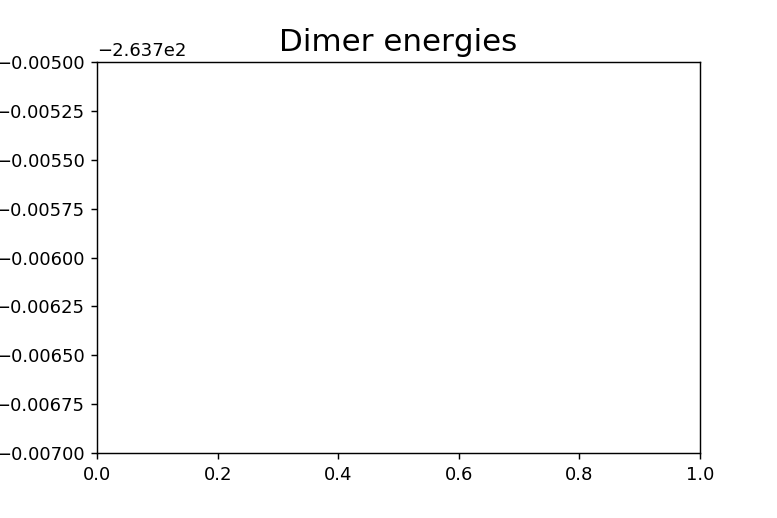

ValueError: x and y must have same first dimension, but have shapes (13,) and (247,)

In [28]:
%matplotlib notebook
if nCUP==1

    plt.figure()
    plt.title("Dimer energies", size='xx-large')
    plt.ylabel("total energy / hartrees", size='x-large')
    plt.ylim([-263.707,-263.705])
    plt.plot(variables[0].ranges,nrg)

In [90]:
if nCUP==2:
    plots=[]
    count=0

    for m in range(len(variables)):
        for n in range(m+1,len(variables)):

            var0=deepcopy(variables[m])
            var1=deepcopy(variables[n])

            X=[]
            Y=[]
            Z=[]

            for v0 in iter(deepcopy(variables[m])):

                x=[]
                y=[]
                z=[]

                for v1 in iter(deepcopy(variables[n])):

                    x.append(v0)
                    y.append(v1)
                    z.append(nrg[count])
                    count+=1

                X.append(x)
                Y.append(y)
                Z.append(z)
    

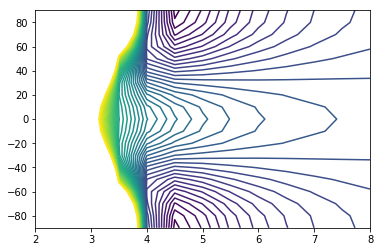

In [60]:
#%matplotlib notebook    
%matplotlib inline
        
min=-263.7075
max=-263.7025
inc=0.0001

x=min
tmp=[]
while x<=max:
    tmp.append(x)
    x+=inc
V=tuple(tmp)
       
fig = plt.figure()
ax = plt.axes()
ax.contour(np.asarray(X), np.asarray(Y), np.asarray(Z), V)
ax.set_xlim(2,8)
ax.set_ylim(-90,90)
plt.show()
 

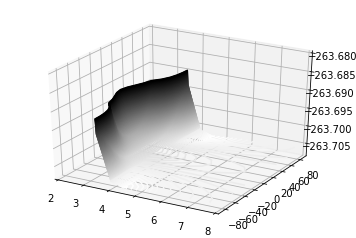

In [73]:
%matplotlib inline
#%matplotlib notebook

min=-263.7075
max=-263.6900
inc=0.0001

x=min
tmp=[]
while x<=max:
    tmp.append(x)
    x+=inc
V=tuple(tmp)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.contour3D(np.asarray(X), np.asarray(Y), np.asarray(Z), V, cmap="binary")
ax.set_xlim(2,8)
ax.set_ylim(-90,90)
ax.set_zlim(-263.708,-263.68)
#ax.view_init(90, 0)
#ax.autoscale()
plt.show()

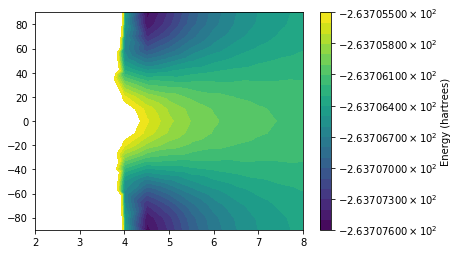

In [126]:
import matplotlib.ticker as ticker

min=-263.7076
max=-263.7055
inc=0.0001

x=min
tmp=[]
while x<=max:
    tmp.append(x)
    x+=inc
V=tuple(tmp)

contour = plt.tricontourf(np.asarray(X).ravel(), np.asarray(Y).ravel(), np.asarray(Z).ravel(), V,)

def fmt(x, pos):
    a, b = '{:.8e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = plt.colorbar(contour, format=ticker.FuncFormatter(fmt))
cbar.set_label('Energy (hartrees)')

plt.show()